# 🛠 Install Libraries

In [1]:
'''
ak_UWMGI[Train]

'''

# インストール済みなので、コメントアウト
#!pip install -q segmentation_models_pytorch
#!pip install -qU wandb
#!pip uninstall --yes scikit-learn
#!pip install -q scikit-learn

'\nak_UWMGI[Train]\n\n'

# 📚 Import Libraries 

In [196]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [197]:
import sys
from PIL import Image
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm import tqdm
tqdm.pandas()
import time
import copy
import joblib
from collections import defaultdict
import gc
from IPython import display as ipd
# tifffile.imread("ファイル名")でtiff画像を読み込める
import tifffile as tiff 

# visualization
import cv2
import matplotlib.pyplot as plt

# Sklearn
from sklearn.model_selection import StratifiedKFold, KFold

# PyTorch 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torch.nn.functional as F

#import timm 今のところ不要

# Albumentations for augmentations
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Unetを使うためのライブラリをインポート(smp)
import segmentation_models_pytorch as smp

# For colored terminal text
from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

# ⚙️ Configuration 

In [198]:
class CFG:                                                       # パラメータ一覧
    mean = np.array([0.7720342,0.74582646,0.76392896])
    std =  np.array([0.24745085,0.26182273,0.25782376])
    work_dir      = "/home/user/Desktop/hirao/ftu_segmentation/"
    ckpt_dir      = "/home/user/Desktop/hirao/ftu_segmentation/models_for_use" # 使用するモデルの置き場所
    
    # 切り取りサイズx,y(imagenetと同じ256x256のパッチに切り分ける)
    x_csize       = 256
    y_csize       = 256    
    
    seed          = 101
    exp_name      = 'v4'
    comment       = 'unet-efficientnet_b0-320x384'
    model_name    = 'Unet'                         # 使用モデル
    backbone      = 'efficientnet-b0'              # エンコーダのネットワーク(Efficientnet)
    train_bs      = 32                             # 学習バッチサイズ
    valid_bs      = train_bs*2                     # 検証バッチサイズ
    img_size      = [3072, 3072]                   # 画像サイズ(この形にリサイズ[パディング])
                                                   # あくまで仮の値。読み込み.csvから最大値を計算して上書きされる。
    epochs        = 5                             # エポック数
#    lr            = 2e-3                           # 学習率
    lr            = 1e-2                           # 学習率
    scheduler     = 'CosineAnnealingLR'            # lrがコサインカーブを描く形で減衰・上昇
    min_lr        = 1e-6                           # 最小学習率
    T_max         = int(30000/train_bs*epochs)+50  # コサインカーブの半周期のステップサイズ[epoch]
                                                   # epochが進むと変動が緩やかになる？
    T_0           = 25                             # 1つめの周期が終わるepoch?
    warmup_epochs = 0                              # 最初の学習率を低めに設定し、指定epochまで上昇させる
    wd            = 1e-6                           # 重みを抑制し過学習を避けるweight decay(L2ノルム)
    n_accumulate  = max(1, 32//train_bs)           # バッチ数が小さいとロスも小さくなるようにする
#    n_accumulate  = 1
    n_fold        = 5                              # データを分割するときの分割数(5の場合,検証:学習=1:4となる)
    folds         = [0,1,2,3,4]                            # フォールド数
    num_classes = 1 # マスクのチャンネルは1つ
    thr           = 0.40
    device        = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    # 背景と見做す白色の割合(0.8以上は背景)
    w_th          = 0.8   
    # 背景除外を使用するかどうか(True or False)
    use_white_area = True

# ❗ Reproducibility

In [199]:
def set_seed(seed = 70):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CFG.seed)

> SEEDING DONE


## Test

In [200]:
'''
ここから実際の推論処理開始
'''

# 推論用のファイルを読み込み
sub_df = pd.read_csv(CFG.work_dir + 'test.csv') # test.csvを読み込みsub_dfに入れる
# データが1行の場合(テスト本番でない場合)
if len(sub_df)==1:                       # データが1行しか入っていない場合,train.csvを読み込む
#if len(sub_df)==0:                       # 1行のテストデータを処理してみるために、設定
    print("only 1 sample sample_submission")
    debug = True                         # debug=>True trainから読み取りの場合Trueとなる
    sub_df = pd.read_csv(CFG.work_dir + 'train.csv') # train.csvを読み込む
#    sub_df = sub_df[:30]                    # 30行までsub_dfに入れる(空のデータはない)
    sub_df = sub_df[:5]                    # [時間短縮用] 5行までsub_dfに入れる(空のデータはない)
#    sub_df = sub_df                    # 全てsub_dfに入れる(メモリ等の負担を確認するために全て読み込む)
    sub_df = sub_df.drop(columns=['rle']).drop_duplicates() # 答えとなる'rle'列だけを除去し、重複した行もあれば除去する。
# データが1行でない場合(テスト本番の場合)
else:
    print("test launch!")
    debug = False                         # debug=>False sample_submissionからの場合False

display(sub_df.head()) # 上から3行を表示する

only 1 sample sample_submission


,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,age,sex
0,10044,prostate,HPA,3000,3000,0.4,4,37.0,Male
1,10274,prostate,HPA,3000,3000,0.4,4,76.0,Male
2,10392,spleen,HPA,3000,3000,0.4,4,82.0,Male
3,10488,lung,HPA,3000,3000,0.4,4,78.0,Male
4,10610,spleen,HPA,3000,3000,0.4,4,21.0,Female


In [201]:
'''
paddingで揃えるべき画像のサイズを求め、CFG.img_sizeを更新する。
'''
# 画像の最大高さを確認する。
max_height = sub_df["img_height"].max()
# 画像の最大幅を確認する。
max_width = sub_df["img_width"].max()
# 画像の最大幅と最大高さの内、大きい方をmax_sizeに入れる。(基本幅と高さは同じと推測)
max_size = max(max_height, max_width)
# Unet最低解像度＝32のため、画像が32の倍数である必要がある。(後に256x256に分割)
# 自動的に最大サイズより大きく、32の倍数に最も近い値をmax_sizeとする。
max_size = max_size + (32 - max_size%32) if max_size%32 != 0 else max_size
CFG.img_size = [max_size, max_size]
print("CFG.img_size:\n",CFG.img_size)

'''
画像パスを要素に持つpath_dfを作成する
'''
if debug: # debug=Trueの場合、つまりtrainからsub_dfを作製した場合
    # paths = 学習フォルダのpngファイルパスのリスト
    paths = glob(CFG.work_dir + 'train_images/**/*tiff',recursive=True)
#     paths = sorted(paths)

else: # 提出したコードが本番で実行される場合
        
    # paths = testフォルダのpngファイルパスのリスト
    paths = glob(CFG.work_dir + 'test_images/**/*tiff',recursive=True)
#     paths = sorted(paths)

# image_path列としてパスをDFとする
path_df = pd.DataFrame(paths, columns=['image_path'])
path_df['id'] = path_df.image_path.map(lambda x: int(x.split('/')[-1].replace('.tiff','')))

path_df.head()

CFG.img_size:
 [3008, 3008]


,image_path,id
0,/home/user/Desktop/hirao/ftu_segmentation/trai...,15732
1,/home/user/Desktop/hirao/ftu_segmentation/trai...,10044
2,/home/user/Desktop/hirao/ftu_segmentation/trai...,15787
3,/home/user/Desktop/hirao/ftu_segmentation/trai...,10274
4,/home/user/Desktop/hirao/ftu_segmentation/trai...,15842


In [9]:
#debug = False          # 学習画像で、画像表示させたくない場合はアンコメント
#debug = True           # テストデータで、画像を表示させてみたい場合はアンコメント。上の方のセルでcsvファイル読み込み時のdebug条件も要変更(if len(sub_df)==1 => len(sub_df)==0)

## Merge Data

In [202]:
'''
sub_dfにimage_path列を追加したtest_dfを作成する (sub_df + path_df)
'''
# testデータセット = id列を元にpath_dfをsub_dfに結合する。
# test_df列＝["id","organ","data_source","img_height","img_width","pixel_size","tissue_thickness","age","sex"]
test_df = sub_df.merge(path_df, on=['id'])
test_df.head()

,id,organ,data_source,img_height,img_width,pixel_size,tissue_thickness,age,sex,image_path
0,10044,prostate,HPA,3000,3000,0.4,4,37.0,Male,/home/user/Desktop/hirao/ftu_segmentation/trai...
1,10274,prostate,HPA,3000,3000,0.4,4,76.0,Male,/home/user/Desktop/hirao/ftu_segmentation/trai...
2,10392,spleen,HPA,3000,3000,0.4,4,82.0,Male,/home/user/Desktop/hirao/ftu_segmentation/trai...
3,10488,lung,HPA,3000,3000,0.4,4,78.0,Male,/home/user/Desktop/hirao/ftu_segmentation/trai...
4,10610,spleen,HPA,3000,3000,0.4,4,21.0,Female,/home/user/Desktop/hirao/ftu_segmentation/trai...


## Load images

In [203]:
def load_img(id,img_path):
#    print("id:",id)
#    print("img_path:",img_path)
    # tiff画像を読み込む
    img = tiff.imread(img_path)
    # 原点のピクセル値確認
#    print("img:\n",img[0,0])
    # 画像の形状を読み込む
    shape0 = np.array(img.shape[:2])            # array([3000,3000])など、元のimg形状を読み込みnp配列にする
    resize = np.array(CFG.img_size)             # array([OOO,OOO])　指定した変更後サイズをnp配列にする
    
    # 画像のサイズ変更において、大きくなる際に歪まない方法
    if np.any(shape0!=resize):                      # 「元サイズ」と「変更後サイズ」が異なる場合に以下の処理をする
        diff = resize - shape0                      # 「元サイズ」「変更後サイズ」の差分
        pad0 = diff[0]                              # diff[0]=差分の縦サイズ
        pad1 = diff[1]                              # diff[1]=差分の横サイズ
        pady = [pad0//2, pad0//2 + pad0%2]          # pady=[差分縦の半分, 差分縦の半分 + 縦の差分を2で割った余り(0 or 1)]
        padx = [pad1//2, pad1//2 + pad1%2]          # padx=padyの横ver
        
        # 画像をrgbに分けて、それぞれ原点のピクセル値で埋め合わせてから、元のRGB画像に戻している。img.shape[2]=チャンネル数(RGB)
        # こちらを使う場合、1行下のnp.pad...をコメントアウト
        img = np.asarray([np.pad(img[:,:,idx], [pady, padx], constant_values=(img[:,:,idx][0,0])) for idx in range(img.shape[2])])
        
        # 画像の周囲を0で埋めている。
        # こちらを使う場合、上記のnp.asarray...をコメントアウト
#        img = np.pad(img, [pady, padx])
        
        img = img.transpose(1,2,0)
        img = img.reshape((*resize, 3))             # 変更前後のサイズにreshape(形状変更):1行前の時点で既にこの形状になっている場合が多いか    

    # 後でmask2rleの際に元の画像サイズが重要となるが、shape0を返す必要があるのどうか、要検討
    return img,id,shape0

'''
画像を読み込み、リストに保管する関数
メモリ節約のため、1枚ずつ読み込めるようにiteratorを使用
'''
def load_imgs(test_df):
    # 1枚1枚の画像を読み込み、loaded_data1に入れる。old_id_shapeには元のidとそのidの元の画像サイズを入れる。
    #loaded_data1 = []
    #old_id_shape = []
    for (id, img_path) in zip(test_df["id"],test_df["image_path"]):
        img,id, shape = load_img(id, img_path)
        
        yield img,[id,shape]
        #loaded_data1.append(img)
        #old_id_shape.append([id,shape])
        
    #return loaded_data1,old_id_shape
        
    # ガベージコレクション
    gc.collect()


## Split images

In [204]:
'''

切り分け用関数
(入力画像をすべて256x256に切り分ける)

関数セル
'''
#画像における背景（白い部分）割合カウント用関数(レベル0ベース)
def count_white_area (img_w):
    
    #グレースケールに変換
    img_grayimg = cv2.cvtColor(img_w, cv2.COLOR_BGR2GRAY)

    #ぼかし
    kernel = np.ones((10,10),np.float32)/100
    blur_img = cv2.filter2D(img_grayimg,-1,kernel)

    #二値化
    #画像サイズにより適宜調整を！！
    # 解像度レベル0は以下
    bi_img = cv2.adaptiveThreshold(blur_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY, 41, 7)

    #近傍の定義
    neiborhood = np.array([[0, 1, 0],[1, 1, 1],[0, 1, 0]],np.uint8)

    # 縮小、膨張
    # 解像度レベル0は以下
    img_dilate = cv2.dilate(bi_img,neiborhood,iterations=3)
    img_erode = cv2.erode(img_dilate,neiborhood,iterations=20)
    
    #白（背景）のピクセル数を算出
    white = cv2.countNonZero(img_erode)
    white_area = white /(img_w.shape[0]*img_w.shape[1])
    
    del img_w
    
    return white_area

# 画像切り取り用の関数(切り取り幅は引数で設定)
def mk_patch_for_ref(loaded_data1, old_id_shape, x_csize, y_csize):
#    print("started!")

    # 旧id_旧shape,j(x),i(y),im_c(カット画像)を入れるリストの枠を用意する
    id_shape_cut_images = []

    # リストから画像ファイル、マスクファイルを読み込む        
    # 画像を取り出す
    im = loaded_data1
        
    # 画像の横幅と縦の長さをそれぞれimg_x, img_yに代入する
    # おそらく0番目がyで1番目がxのはず
    img_x = im.shape[1]
    img_y = im.shape[0]
        
    # 画像サイズのyを切り取り、サイズで割った回数繰り返す。(例: 画像のy=32を8ずつ切りたい場合=> 32/8 = 4回)
    for i in range(int(img_y / y_csize)):
        # 画像サイズのxを切り取りサイズで割った回数繰り返す。(例: 画像のx=24を8ずつ切りたい場合=> 24/8 = 3回)
        for j in range(int(img_x / x_csize)):
                
            # 画像を切り取り
            # 指定サイズに切り取る(x_csize * j＝ x座標のスタート、y_csize * i = y座標のスタート)
            # im[y_start:y_end, x_start:x_end]
            # y＝＞xの順なので要注意
            im_c = im[y_csize * i : y_csize * i + y_csize, x_csize * j : x_csize * j + x_csize]

            # 背景削除用のCV2形式画像の切り取り
#               im_cv2_c = im_cv2[y_csize * i : y_csize * i + y_csize, x_csize * j : x_csize * j + x_csize]
                
            # 背景除外の関数を用いる場合は、count_white_area関数を呼び出す。
            if CFG.use_white_area:
#                   white_area = count_white_area(img_w = im_cv2_c)
                # 背景処理にopenCVを用いるので、im_cをcv2形式に変換してから入力する。
                white_area = count_white_area(img_w = cv2.cvtColor(im_c, cv2.COLOR_RGB2BGR))
            else:
                # 背景除外しないなら、0にしておく。
                white_area = 0
                                
            # モデルに入れるための前処理
            im_c = im_c.astype('float32') # original is uint8か
            # 最大画素値で割り、[0-1]のnumpy配列imgに変換して返す
#            # 正規化の場合
#            im_c /= 255.0
            # 標準化の場合
            im_c = (im_c/255.0 - CFG.mean)/CFG.std

            #白の割合がw_th以上のものは推論の対象外とする。
            if white_area < CFG.w_th:
                # 旧id,旧shape,j,i,画像をid_shape_imagesリストに保管する。
                id_shape_cut_images.append([old_id_shape[0],old_id_shape[1],j,i,im_c])
                    
    # 各画像の切り分け完了後は、元画像のimも背景処理用に用意したim_cv2も不要なので削除する。
#    del im,im_cv2,im_cv2_c
    del im
        
    # [[id,shape,j,i,カット画像],...]のリストを返す
    return id_shape_cut_images


In [205]:
'''
画像とID、旧形状の情報を取り出すためのイテレータ
BuildDatasetでデータセットを作成する際に必要
'''
load_imgs_i = load_imgs(test_df)

# 🍚 Dataset

In [206]:
# 推論用データからデータセットを作成するクラス
class BuildDataset(torch.utils.data.Dataset):
    # dfを入れる。
    def __init__(self, id_shape_cut_images, transforms=None):
        # まず、id_shape_cut_imagesをセットする, 各項目は__getitem__で取り出す
        self.df         = id_shape_cut_images        
        # 初期self.transormsにtransformsを入れる。transformsには、基本的にdata_transformsから"valid"か"train"か選んだ場合の前処理が入る。
        self.transforms = transforms
        
    # dfの長さを返す
    def __len__(self):
        return len(self.df)
    
    # インデックスを指定して画像を取り出す(img_pathの画像毎のパスからindex番目の画像パスを取り出し、画像を読み込み)
    def __getitem__(self, index):
        # "ids_old"をido_に入れる
        ido_   = self.df[index][0]
        # 元画像の高さ、幅をh,wに入れる
        h,w    = self.df[index][1]
        # カット画像のx番号をxに入れる
        x      = self.df[index][2]
        # カット画像のy番号をyに入れる
        y      = self.df[index][3]
        # カット画像のデータをimgに入れる
        img    = self.df[index][4]
        # 前処理(transforms)指定があれば、実施してdataに入れる。変換後のdata['image']をimgに入れる
        if self.transforms:
            data = self.transforms(image=img)
            img  = data['image']
        img = np.transpose(img, (2, 0, 1))
        return torch.tensor(img), ido_, x, y, h, w 

# 🌈 Augmentations

In [207]:
#API albumentaitonでデータ拡張
data_transforms = {
    # 学習(train)を指定した場合、データ拡張のAlbumentationsライブラリで以下の処理を実施(画像もマスクも同じように拡張してくれる)
    # 水平フリップ(50%)、垂直フリップ(50%)、及び("グリッド歪み"か"弾性変形")のどちらか片方をランダムで行う(25%)。
    "train": A.Compose([
#         A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
#         A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.05, rotate_limit=5, p=0.5),
        A.OneOf([
            A.GridDistortion(num_steps=5, distort_limit=0.05, p=1.0),
# #             A.OpticalDistortion(distort_limit=0.05, shift_limit=0.05, p=1.0),
            A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=1.0)
        ], p=0.25),
#         A.CoarseDropout(max_holes=8, max_height=CFG.img_size[0]//20, max_width=CFG.img_size[1]//20,
#                          min_holes=5, fill_value=0, mask_fill_value=0, p=0.5),
        ], p=1.0),
    # 検証(valid)を指定した場合、特に何も行わない(コメント削除でリサイズ)
    "valid": A.Compose([
#         A.Resize(*CFG.img_size, interpolation=cv2.INTER_NEAREST),
        ], p=1.0)
}

In [208]:
# ガベージコレクション
gc.collect()

86927

# 📦 Model

In [209]:
# Unetを構築する
def build_model():
    model = smp.Unet( # Unetの場合はこちら
#    model = smp.UnetPlusPlus( # UnetPlusPlusの場合はこちら
        # エンコーダーにbackboneで指定したefficientnet-b0を使用
        encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
        # 重みはなし(テストでありモデルを読み込むから。学習時はimagenetを指定することで事前学習した重みを使える。)
        encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
        # インプットチャンネル数
        in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
        # アウトプットチャンネル数（=1[クラス数]）
        classes=CFG.num_classes,        # model output channels (number of classes in your dataset)
        # 活性化関数(なし)
        activation=None,
    )
    model.to(CFG.device) # モデルをcuda(あれば)に送る
    return model

def load_model(path):
    model = build_model()
    # モデルを読み込む
    model.load_state_dict(torch.load(path))
    # モデルを評価モードに切り替え
    model.eval()
    return model

# 🔨 Helper

In [210]:

#import cupy as cp

# マスク画像からランレングス符号への変換用関数
# cupy:GPUで高速計算に対応したNumpyと互換性のある計算ライブラリ

# サーバーでは、cupyがないので、numpyで実行
def mask2rle(msk, thr=0.5):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
#    msk    = cp.array(msk)
    msk    = np.array(msk)
    pixels = msk.T.flatten()
#    pad    = cp.array([0])
    pad    = np.array([0])
#    pixels = cp.concatenate([pad, pixels, pad])
    pixels = np.concatenate([pad, pixels, pad])
#    runs   = cp.where(pixels[1:] != pixels[:-1])[0] + 1
    runs   = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# マスク複数をランレングス符号に変換
def masks2rles(msk_org, ids_old_f, height, width):
    pred_strings = []; pred_ids = [];
    shape0 = np.array([height, width]) # 最初のサイズ
    resize = np.array(CFG.img_size) # リサイズ後のサイズ
    '''
    画像をresizeしているので、マスクを一番最初のサイズ(shape0)に戻す
    '''
    if np.any(shape0!=resize): # 元サイズとリサイズ後の画像サイズが違う場合
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        msk_org = msk_org[pady[0]:-pady[1], padx[0]:-padx[1], :]
        # (3000,3000,1)等。マスクは1チャンネル
        msk_org = msk_org.reshape((*shape0, 1))
    '''
    画像をresizeしているので、マスクを一番最初のサイズ(shape0)に戻す(ここまで)
    '''
    '''
    マスクからランレングス符号に変換
    '''
    rle = [None]
    rle = mask2rle(msk_org)
    #if ids_old_f == 10044: print("len_rle[0]:\n",len(rle))
    # rleをpred_stringsリストに追加する
    pred_strings.append(rle)
    #if ids_old_f == 10044: print("len_pred_strings:\n",len(pred_strings))
    # idをpred_idsリストに追加する,ids_old_fはリストではないので、二重になることはない。
    # appendで普通に追加
    pred_ids.append(ids_old_f)
    '''
    マスクからランレングス符号に変換(ここまで)
    '''
    # ランレングス符号リストと、pred_idsリストを返す
    return pred_strings, pred_ids

# 🔭 Inference

In [211]:
@torch.no_grad()
# 推論：モデルパス、テスト用データローダー、ログ数、thr(閾値)を指定
def infer(model_paths, test_loader, num_log=1, thr=CFG.thr):
    # ido_indexは、旧idのインデックス番号。元画像のidが切り替わるごとに+1していく
    ido_index = 0

    # msks, imgs を空のリストで初期化
    msks = []; imgs = [];
    # pred_strings, pred_ids, pred_classesも空のリストで初期化
    pred_strings = []; pred_ids = [];
    # test_loaderから、画像をバッチサイズ(128個)ずつimgに入れて繰り返し推論。合計値はtest_loaderの長さ(合計数÷バッチサイズ),表示名は"Infer"
    # DataLoaderからimg、ids、元ids, 旧高さ、旧幅が出力されるのでそれぞれiterationの中で使用
    '''
    ローダーからは元画像単位で切れるように
    バッチサイズを調整するか？36がベストかも？
    そうなると学習もバッチ数36が良いのか？
    '''
    # 部分マスクを貼り合わせた元サイズのマスクが入るリストを初期化
    org_masks = []

    '''
    バッチサイズごとの処理部分
    '''
    # img,ids_old,x,y,元heights,元widths全てバッチサイズでくっついているので要注意
    # バッチサイズ=64なら、imgもidsも全て64個ずつ入っている。
#    for idx, (img, ids_old, xs, ys, heights, widths) in enumerate(tqdm(test_loader, total=len(test_loader), desc='Infer ')):
    for idx, (img, ids_old, xs, ys, heights, widths) in enumerate(test_loader):
        # 初回の繰り返しのみ、ids_old_fにids_oldを代入
        if idx == 0:
            ids_old_f = ids_old[0]
            #print("ids_old_f:",ids_old_f)
            # 最初にmsk_orgを要素ゼロnumpy配列で定義、以降はmsk_orgが完成し、rleに変換される度に要素ゼロにリセット
            # 元のold_id_shapeのid,shapeを元に、要素ゼロでリサイズされたshape,チャンネル数1のnumpy配列を用意(h,w,ch数)
            # id毎にnumpyで用意する。ido_indexが元IDの番号
            msk_org = np.zeros((CFG.img_size[0], CFG.img_size[1], 1), dtype=np.float32)
            #print("msk_org:",len(msk_org))        

        # カット画像imgをcudaに送る
        img = img.to(CFG.device, dtype=torch.float) # .squeeze(0)
        # 画像サイズ (バッチサイズ,画像チャンネル,画像サイズ,画像サイズ)
        size = img.size() 
        '''
        カット画像のマスク推論
        '''
        # マスク処理をコメントアウトしたいとき
        #'''
        msk = []
        # mskを,チャンネル数以外はimgと同じサイズ＋要素ゼロのテンソルで作る。(バッチ数、チャンネル数=1(imgは3なので気を付ける)、高さ、幅)
        msk = torch.zeros((size[0], 1, size[2], size[3]), device=CFG.device, dtype=torch.float32)
        # モデルパスが複数あるので１つずつ読み込み、読み込み、Sigmoidを通して0~1に変換することでチャンネル軸を削除
    #        print("model:\n",model_paths)
        for path in model_paths:
#            print("path",path)
            model = load_model(path)
            out   = model(img) # .squeeze(0) # removing batch axis
            out   = nn.Sigmoid()(out) # removing channel axis
            # 要素ゼロのmskに出力/モデル数を加える (ベストモデル全体の平均,前回を超えるごとにベストモデルが保存されるはず,その平均)
            msk+=out/len(model_paths)
        # mskの軸の順番を指定して入れ替えて(バッチ数、高さ、幅、チャンネル)にし、上記でsigmoidに通した後0.4より大きい値だけを残す。その後numpyに変換。
        msk = (msk.permute((0,2,3,1))>thr).to(torch.uint8).cpu().detach().numpy() # shape: (n, h, w, c)
        # マスク処理をコメントアウトしたいとき
        #'''
        '''
        カット画像のマスク推論（ここまで）
        '''
    
        # msk_orgのリストを初期化、loaded_data1と比較して後で表示する
        msk_orgs = []

        '''
        バッチ数回繰り返すことで、マスク(256x256)1枚ずつ処理していく
        元マスクサイズ(OOOxOOO)＋ゼロ要素のnumpyに、マスク(256x256)を貼り付けていく
        '''
        for idx_s,(msk_s, ids_old_s, x, y, height, width) in enumerate(zip(msk, ids_old, xs, ys, heights, widths)):
            # 元画像のIDが切り替わったら、ido_indexを+1して、マスク＝＞ランレングス符号処理をしていく
            
            # チェック用
#            print("ids_old_s:",ids_old_s)
#            print("ids_old_f:",ids_old_f)
#            print("同じじゃない？:",ids_old_s != ids_old_f)
            
            if ids_old_s != ids_old_f:
                ido_index += 1
                #print("ido_index:",ido_index)

                '''
                マスク＝＞ランレングス、リスト保管
                '''
                # マスク処理をコメントアウトしたいとき
                #'''
#                print("ids_old_sa:",ids_old_s)
                # result = マスク(numpy)をランレングス符号に変換したもの
                result = masks2rles(msk_org, ids_old_f.item(), height, width)
                # extendはappendに似ているが、リストを追加する場合だけ異なる。元のリストに後ろからリストを追加し1つに融合する。(appendでリストをリストに追加すると二重リストになる)
                # pred_strings に result[0]：ランレングス符号に追加
                pred_strings.extend(result[0])
                # pred_ids に result[1]:IDを追加
                pred_ids.extend(result[1])

                # 不要になったデータを削除
                del result
                
                # debug=Trueの場合は、msk_orgをリセットする前にリストに入れていく。
                if debug:
                    org_masks.append(msk_org)
                # msk_orgがrleに変換されたので、要素ゼロにリセット
                # 元のold_id_shapeのid,shapeを元に、要素ゼロで旧shape,チャンネル数1のnumpy配列を用意(h,w,ch数)
                # id毎にnumpyで用意する。ido_indexが元IDの番号
                msk_org = np.zeros((CFG.img_size[0], CFG.img_size[1], 1), dtype=np.float32)

                '''
                マスク＝＞ランレングス、リスト保管(ここまで)
                '''

            # mskをmsk_orgに貼り付けるため、x_start,end,y_start,endをx,yから用意する。
            x_start = x * CFG.x_csize
            y_start = y * CFG.y_csize
            x_end = x_start + CFG.x_csize
            y_end = y_start + CFG.y_csize
            # msk_orgのx,yが示す箇所にmskを貼り付ける。
            # msk_org[y_start:y_end, x_start:x_end]なので要注意
            msk_org[y_start:y_end, x_start:x_end] = msk_s

            # この繰り返しが終わった時点のids_oldを, ids_old_fに記録しておく
            ids_old_f = ids_old_s 

            if idx == len(test_loader)-1 and idx_s == len(msk)-1:        
                #print(idx)
                #print("last_one")

                '''
                マスク＝＞ランレングス、リスト保管2 (最後のバッチ、最後のID)
                '''
                # マスク処理をコメントアウトしたいとき
                #'''
                # result = マスク(numpy)をランレングス符号に変換したもの
                result = masks2rles(msk_org, ids_old_f.item(), height, width)
                # extendはappendに似ているが、リストを追加する場合だけ異なる。元のリストに後ろからリストを追加し1つに融合する。(appendでリストをリストに追加すると二重リストになる)
                # pred_strings に result[0]：ランレングス符号に追加
                pred_strings.extend(result[0])
                # pred_ids に result[1]:IDを追加
                pred_ids.extend(result[1])

                # 不要になったデータを削除
                del result
                
                # debug=Trueの場合は、msk_orgをリセットする前にリストに入れていく。
                if debug:
                    org_masks.append(msk_org)
                # msk_orgがrleに変換されたので、要素ゼロにリセット
                # 元のold_id_shapeのid,shapeを元に、要素ゼロで旧shape,チャンネル数1のnumpy配列を用意(h,w,ch数)
                # id毎にnumpyで用意する。ido_indexが元IDの番号
                msk_org = np.zeros((CFG.img_size[0], CFG.img_size[1], 1), dtype=np.float32)
                '''
                マスク＝＞ランレングス、リスト保管2(ここまで)
                '''

        # idxが1より小さい、つまり最初のバッチで、かつdebug=True(trainから列を読み込み、つまり初回？)の場合、
        # imgの軸を並び替えてnumpy変換し、imgsリストに4つおきに追加(推論結果サンプル用)、msksリストに同じく4つおきにmskを追加            
        if idx<num_log and debug:
            img = img.permute((0,2,3,1)).cpu().detach().numpy()
            # バッチ中5個だけ取り出し
            imgs.append(img[::5])
            msks.append(msk[::5])
        # メモリ節約用(img,msk,modelを削除)
#        del img, msk, out,model
#        del img, msk, model
        # ガベージコレクション
        gc.collect()
        # GPUメモリの開放
        torch.cuda.empty_cache()


    #マスク処理をコメントアウトしたいとき
    #'''
    # [ランレングス符号リスト、 IDリスト, クラスリスト、推論結果サンプル用画像、推論結果サンプル用マスク]を返す
    if debug:
        return pred_strings, pred_ids, imgs, msks, org_masks
    else:
        return pred_strings, pred_ids, imgs, msks

In [212]:
'''
推論開始
'''
# 予測rle,該当id,img,msk,org_maskのリストを用意する
pred_strings=[]; pred_ids=[]; imgs=[]; msks=[]; org_masks=[]
# debugモードで、全体画像を残すため。
# メモリ不足になるので要注意!
loaded_data1=[]
# test_dfの長さ、つまり、元画像の枚数だけ繰り返す
for i in tqdm(range(len(test_df)),total=len(test_df), desc='Infer '):
    # データセットを呼び出す直前に、元id単位で画像を読み込み、カット画像を用意する
    loaded_data, old_id_shape = next(load_imgs_i)
    id_shape_cut_images = mk_patch_for_ref(loaded_data, old_id_shape, CFG.x_csize, CFG.y_csize)
    
    # debug=Trueなら、画像を残しておくようにする。
    # ただし、メモリ対策時には必ずコメントアウトすること。そうでないとメモリ不足となる!
    if debug == True:
        loaded_data1.append(loaded_data)
        
    # 評価用データセットを作成(load_imgsやload_msk、albumentationによる前処理もこの中で実施)
    test_dataset = BuildDataset(id_shape_cut_images, transforms=data_transforms['valid'])

    # 指定したバッチサイズ(valid_bs = 128)でデータローダーを作成,test_loaderとする。
    test_loader  = DataLoader(test_dataset, batch_size=27,
                              num_workers=4, shuffle=False, pin_memory=False)
    # モデルパスを指定
    model_paths  = glob(f'{CFG.ckpt_dir}/best_epoch*.bin')
#    print("modelpath:",model_paths)
    # バッチごとの推論を実施し、ランレングス符号リスト、IDリスト、クラスリスト、推論結果サンプル画像、推論結果サンプルマスクを取得
    if debug:
        pred_string, pred_id, img, msk, org_mask = infer(model_paths, test_loader)
        
        # 元画像毎に、リストに結果を保管していく
        pred_strings.extend(pred_string)
        pred_ids.extend(pred_id)
        imgs.extend(img)
        msks.extend(msk)
        org_masks.extend(org_mask)
        
    else:
        pred_string, pred_id, img, msk = infer(model_paths, test_loader)
        
        # 元画像毎に、リストに結果を保管していく
        pred_strings.extend(pred_string)
        pred_ids.extend(pred_id)
        imgs.extend(img)
        msks.extend(msk)

Infer : 100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [00:25<00:00,  5.07s/it]


# 📈 Visualization

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


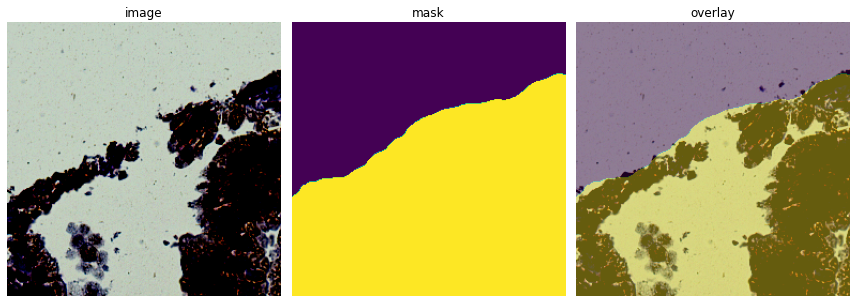

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


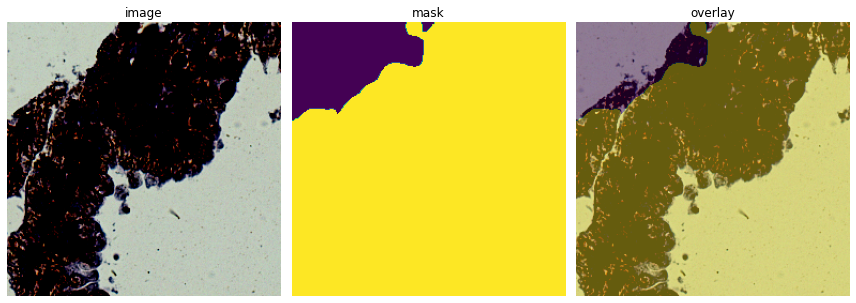

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


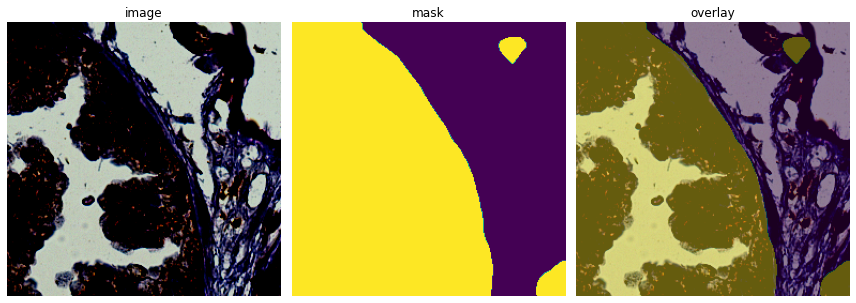

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


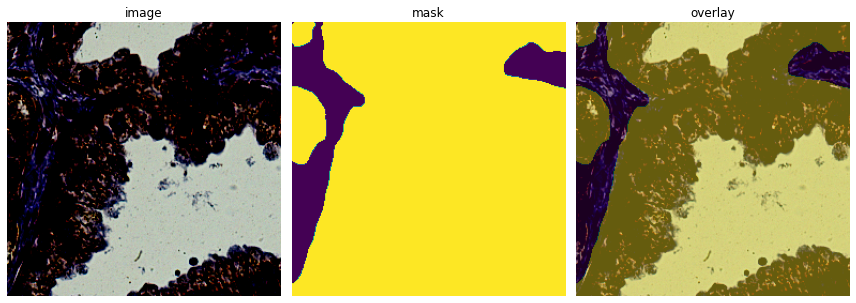

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


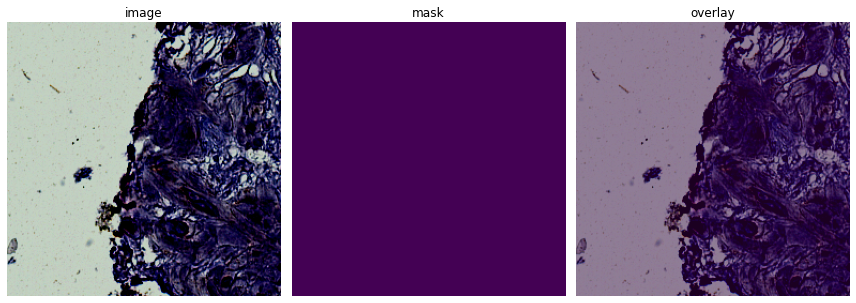

In [213]:
'''
パッチ単位の確認
'''
if debug:
    for img, msk in zip(imgs[0][:5], msks[0][:5]):
        plt.figure(figsize=(12, 7))
        plt.subplot(1, 3, 1); plt.imshow(img, cmap='bone');
        plt.axis('OFF'); plt.title('image')
        # mskは各チャンネルの値が0か1なので、255を掛けることで(1,0,0)なら赤(255,0,0)になる。
        plt.subplot(1, 3, 2); plt.imshow(msk*255); plt.axis('OFF'); plt.title('mask')
        plt.subplot(1, 3, 3); plt.imshow(img, cmap='bone'); plt.imshow(msk*255, alpha=0.4);
        plt.axis('OFF'); plt.title('overlay')
        plt.tight_layout()
        plt.show()

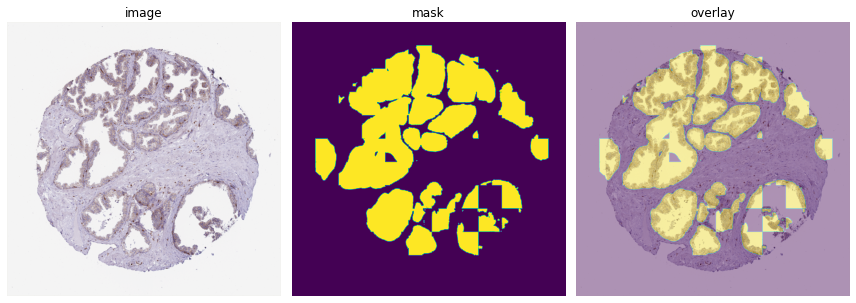

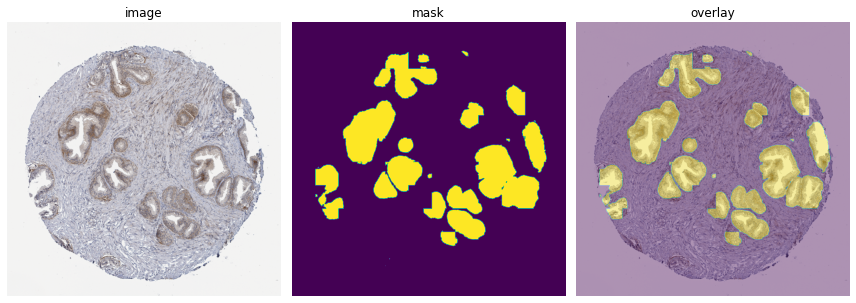

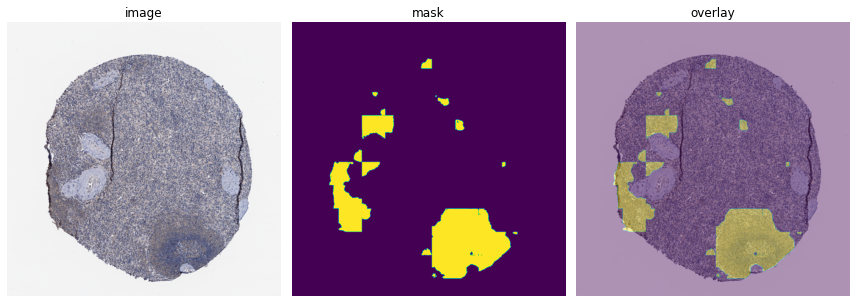

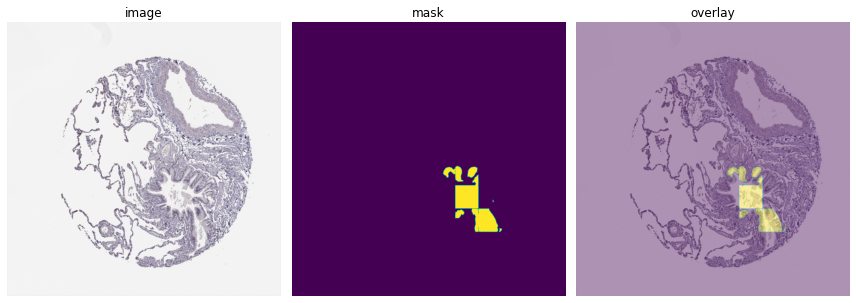

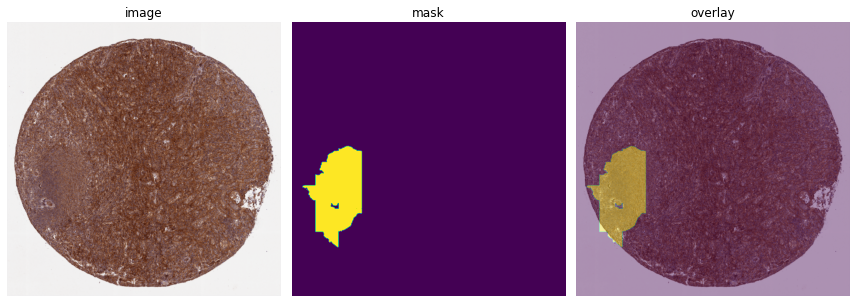

In [214]:
'''
tiff単位の確認① 予測maskを画像に重ね合わせ
'''
if debug:
    for img, msk in zip(loaded_data1[:5], org_masks[:5]):
        plt.figure(figsize=(12, 7))
        plt.subplot(1, 3, 1); plt.imshow(img, cmap='bone');
        plt.axis('OFF'); plt.title('image')
        # mskは各チャンネルの値が0か1なので、255を掛けることで(1,0,0)なら赤(255,0,0)になる。
        plt.subplot(1, 3, 2); plt.imshow(msk*255); plt.axis('OFF'); plt.title('mask')
        plt.subplot(1, 3, 3); plt.imshow(img, cmap='bone'); plt.imshow(msk*255, alpha=0.4);
        plt.axis('OFF'); plt.title('overlay')
        plt.tight_layout()
        plt.show()

In [148]:
if debug:
    del imgs, msks, loaded_data1, org_masks
else:
    del imgs, msks
gc.collect()

86920

# 📝 Submission

In [149]:
# 予測結果をDFに入れる(id列、クラス列、予測結果)
pred_df = pd.DataFrame({
    "id":pred_ids,
    "rle":pred_strings
})

# sample_submission.csvを読み込んだ上でrle列を削除
sub_df = pd.read_csv('/home/user/Desktop/hirao/ftu_segmentation/sample_submission.csv')
del sub_df['rle']

if debug:
    # 学習データの場合、sample_submissionの行は0なので、外部結合する
    # まず、一行目を削除
    sub_df = sub_df.drop(0)
    # 外部結合
    sub_df = sub_df.merge(pred_df, on=['id'], how="outer")
else:
    # 本番データの場合、sample_submissionの行が500行前後あるはずなので、内部結合させる。
    # デフォルトが内部結合なので、ある行だけで結合する
    sub_df = sub_df.merge(pred_df, on=['id'])

sub_df.to_csv('submission.csv',index=False)
display(sub_df.head(5))

,id,rle
0,10044,757308 225 760309 224 763309 224 766309 224 76...
1,10274,757612 177 760613 176 763589 2 763611 178 7665...
2,10392,1294759 5 1294776 8 1297669 6 1297754 8 129777...
3,10488,4597851 35 4600852 34 4603808 3 4603851 34 460...
4,10610,418909 4 421905 10 424902 14 427901 16 430900 ...


# 📈 Visualization2 [mask => rle作成後の確認]

In [150]:
# tiff単位の確認②用の関数　[ランレングス符号➡mask]
def rle2mask(mask_rle, shape=(1600,256)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (width,height) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


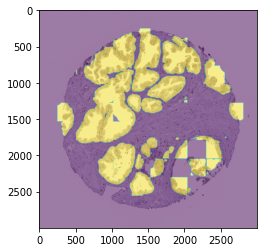

In [151]:
'''
tiff単位の確認② 予測rleからマスクを再生成して、元画像と重ね合わせ
'''
if debug:
    img_t = tiff.imread('/home/user/Desktop/hirao/ftu_segmentation/train_images/10044.tiff') # 学習画像の比較
#    img_t = tiff.imread('/home/user/Desktop/hirao/ftu_segmentation/test_images/10078.tiff')  # テスト画像の比較 
    msk_rle = sub_df.iloc[0,1]
    msk_t = rle2mask(msk_rle, (img_t.shape[:2][1], img_t.shape[:2][0]))
    plt.imshow(img_t)
    plt.imshow(msk_t,alpha=0.5)
    #plt.imshow(msk_t_ud_r270,alpha=0.5)
    plt.show()


In [27]:
# 使用データの削除
if debug:
    del img_t, msk_rle, msk_t

In [17]:
# 他投稿の調査用テスト
from sklearn.model_selection import KFold
kf = KFold(n_splits=4,random_state=200,shuffle=True)
ids = pd.read_csv('/home/user/Desktop/hirao/ftu_segmentation/train.csv').id.astype(str).values
ids
ids[list(kf.split(ids))[0][0]]
fnames = [fname for fname in os.listdir('/home/user/Desktop/hirao/ftu_segmentation/train_c/') if fname.split('_')[0] in ids]


In [86]:
x = np.load('/home/user/Desktop/hirao/ftu_segmentation/train_c/10044_10_4.npy')
x = x.astype('float32')
x /= 255
print(x.shape)
#print(x.shape)
#print(x[1])
#print(x)
r = x[:,:,0]
g = x[:,:,1]
b = x[:,:,2]
r_mean = np.mean(r)
g_mean = np.mean(g)
b_mean = np.mean(b)
r_sum = np.sum(r)
print(r_sum/r.size)
print([r_mean, g_mean, b_mean])
print(r)
#np.mean(x,axis=0)


(256, 256, 3)
0.8208667039871216
[0.8208667, 0.7980982, 0.8377671]
[[0.9529412  0.9607843  0.95686275 ... 0.9607843  0.95686275 0.9607843 ]
 [0.9607843  0.9607843  0.95686275 ... 0.94509804 0.9607843  0.9607843 ]
 [0.9529412  0.9607843  0.9607843  ... 0.9607843  0.95686275 0.9607843 ]
 ...
 [0.87058824 0.83137256 0.7764706  ... 0.9607843  0.95686275 0.9607843 ]
 [0.78431374 0.72156864 0.7058824  ... 0.9607843  0.9607843  0.9529412 ]
 [0.7019608  0.6784314  0.72156864 ... 0.9607843  0.9607843  0.9607843 ]]
8


In [90]:
'''
r,g,bごとに全画像の平均値を求める
'''
x = os.path.join(CFG.work_dir,"train")
y = glob(x+"/*.npy")
r_sums = []
g_sums = []
b_sums = []
r_sizes = []
g_sizes = []
b_sizes = []

for i in y:
    a = np.load(i)
    a = a.astype('float32')
    a /= 255
    r = a[:,:,0]
    g = a[:,:,1]
    b = a[:,:,2]
    r_sum = np.sum(r)
    g_sum = np.sum(g)
    b_sum = np.sum(b)
    r_len = r.size
    g_len = g.size
    b_len = b.size
    r_sums.append(r_sum)
    g_sums.append(g_sum)
    b_sums.append(b_sum)
    r_sizes.append(r_len)
    g_sizes.append(g_len)
    b_sizes.append(b_len)

# r_sizes,g_sizes,b_sizes=1枚毎の要素数のリスト, r_size_t=r要素数の合計
r_size_t = np.sum(r_sizes)
g_size_t = np.sum(g_sizes)
b_size_t = np.sum(b_sizes)
# r_sums,g_sums,b_sums=1枚毎の合計のリスト, r_sum_t=r全合計
r_sum_t = np.sum(r_sums)
g_sum_t = np.sum(g_sums)
b_sum_t = np.sum(b_sums)

# r,g,bそれぞれの全画像での平均ピクセル値
r_mean = r_sum_t / r_size_t
g_mean = g_sum_t / g_size_t
b_mean = b_sum_t / b_size_t

print([r_mean,g_mean,b_mean])

[0.836421453337686, 0.8124928898583412, 0.8292974005322096]


In [91]:
'''
r,g,bごとに全画像の標準偏差を求める
'''
r_sqs=[]
g_sqs=[]
b_sqs=[]

for i in y:
    a = np.load(i)
    a = a.astype('float32')
    a /= 255
    r = a[:,:,0]
    g = a[:,:,1]
    b = a[:,:,2]
    r_dif_sq = (r - r_mean)**2
    g_dif_sq = (g - g_mean)**2
    b_dif_sq = (b - b_mean)**2
    r_sq_sum = np.sum(r_dif_sq)
    g_sq_sum = np.sum(g_dif_sq)
    b_sq_sum = np.sum(b_dif_sq)
    # 1枚毎の偏差の和をr,g,b_sqsに入れる
    r_sqs.append(r_sq_sum)
    g_sqs.append(g_sq_sum)
    b_sqs.append(b_sq_sum)

# 全偏差の合計の平方根を出す。
r_sqs_sr = np.sqrt(np.sum(r_sqs))
g_sqs_sr = np.sqrt(np.sum(g_sqs))
b_sqs_sr = np.sqrt(np.sum(b_sqs))

# 標準偏差を出す。
r_std = r_sqs_sr / r_size_t
g_std = g_sqs_sr / g_size_t
b_std = b_sqs_sr / b_size_t

print([r_std,g_std,b_std])

[2.9024501467060536e-06, 3.36166705916146e-06, 3.1559653497640376e-06]


In [89]:
xxx = np.array([10,1,3,5,31,4313,41])
(xxx - 10)**2

array([       0,       81,       49,       25,      441, 18515809,
            961])